# Resale Price Predictions

## 1.Project Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer


## 2.Data Management

### 2.1.Data Loading and Concatenation

In [2]:
resale1_df = pd.read_csv('ResaleFlatPrices2012-2018.csv')
resale2_df = pd.read_csv('ResaleFlatPrices2019-2024.csv')

resale_df = pd.concat([resale1_df, resale2_df])

In [3]:
resale_df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,257800.0
1,2012-01,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,263000.0


## 2.2.Initial Data Processing

**Convert columns to appropriate formats and perform initial transformations.**

In [4]:
resale_df['month'] = pd.to_datetime(resale_df['month'])
resale_df['year'] = resale_df['month'].dt.year
resale_df['month'] = resale_df['month'].dt.month
resale_df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,257800.0,2012
1,1,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,263000.0,2012


## 3.Feature Engineering and Preparation

### 3.1.Score Creation

In [5]:
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred, squared=False))

rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

### 3.2.Lease Remaining Calculation

In [6]:
resale_df['remaining_lease'] = (99 + resale_df['lease_commence_date']) - resale_df['year']
resale_df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,257800.0,2012,66
1,1,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,263000.0,2012,65


### 3.3.Integration of External Data Sources

#### 3.3.1.Regional Mapping

**Reading and merging external data like MRT locations, schools, malls, and zipcode mapper**

In [7]:
mrt_locations = pd.read_csv('sg-mrt-existing-stations.csv')
mrt_locations.rename(columns= {"latitude": "lat", "longitude": "lng"}, inplace=True)

mrt_upcoming = pd.read_csv('sg-mrt-planned-stations.csv')
mrt_upcoming.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)

school_locations = pd.read_csv('sg-primary-schools.csv')
school_locations.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)

mall_locations = pd.read_csv('sg-shopping-malls.csv')
mall_locations.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)

zipcode_mapper = pd.read_csv('sg_zipcode_mapper_utf.csv')
zipcode_mapper.rename(columns = {"latitude": "lat", "longtitude": "lng", "blk_no": "block", "RD_name": "street_name"}, inplace=True)

In [8]:
regions_mapper = {'ANG MO KIO':'North East', 'BEDOK':'East', 'BISHAN':'Central', 'BUKIT BATOK':'West', 'BUKIT MERAH':'Central',
       'BUKIT PANJANG':'West', 'BUKIT TIMAH':'Central', 'CENTRAL':'North', 'CHOA CHU KANG':'West',
       'CLEMENTI':'West', 'GEYLANG':'Central', 'HOUGANG':'North East', 'JURONG EAST':'West', 'JURONG WEST':'West',
       'KALLANG/WHAMPOA':'Central', 'MARINE PARADE':'Central', 'PASIR RIS':'East', 'PUNGGOL':'North East',
       'QUEENSTOWN':'Central', 'SEMBAWANG':'North', 'SENGKANG':'North East', 'SERANGOON':'North East', 'TAMPINES':'East',
       'TOA PAYOH':'Central', 'WOODLANDS':'North', 'YISHUN':'North'}

resale_df['region'] = resale_df['town'].map(regions_mapper)
resale_df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease,region
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,257800.0,2012,66,North East
1,1,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,263000.0,2012,65,North East


In [9]:
resale_df_with_coord = pd.merge(resale_df,
                                zipcode_mapper[['block', 'street_name', 'lat', 'lng']],
                                how='left',
                                on = ['block', 'street_name'])
resale_df_with_coord.dropna(inplace=True)
resale_df_with_coord.drop_duplicates(inplace=True)
resale_df_with_coord.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease,region,lat,lng
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,257800.0,2012,66,North East,1.362005,103.853880
1,1,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,263000.0,2012,65,North East,1.366227,103.850086


#### 3.3.2.Proximity to Amenities

**Nearest Neighbors algorithm to find the distance from properties to various amenities**

In [10]:
from sklearn.neighbors import NearestNeighbors

# Calculating Distance to Existing MRT Stations
nn_model_mrt = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mrt.fit(mrt_locations[['lat', 'lng']])
resale_df_with_coord['mrt_dist'], indices = nn_model_mrt.kneighbors(resale_df_with_coord[['lat', 'lng']])
resale_df_with_coord

# Calculating Distance to Schools
nn_model_school = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_school.fit(school_locations[['lat', 'lng']])
resale_df_with_coord['school_dist'], indices = nn_model_school.kneighbors(resale_df_with_coord[['lat', 'lng']])

# Calculating Distance to Malls
nn_model_mall = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mall.fit(mall_locations[['lat', 'lng']])
resale_df_with_coord['mall_dist'], indices = nn_model_mall.kneighbors(resale_df_with_coord[['lat', 'lng']])

# Calculating Distance to Upcoming MRT Stations
nn_model_mrt_upcoming = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mrt_upcoming.fit(mrt_upcoming[['lat', 'lng']])
resale_df_with_coord['upcoming_mrt_dist'], indices = nn_model_mrt_upcoming.kneighbors(resale_df_with_coord[['lat', 'lng']])

In [11]:
resale_df_with_coord.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease,region,lat,lng,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,257800.0,2012,66,North East,1.362005,103.853880,0.004521,0.001972,0.003881,0.019054
1,1,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,263000.0,2012,65,North East,1.366227,103.850086,0.003707,0.000663,0.003266,0.019245


**Clean up `nan`, duplicates and drop `lat`, `lng`**

In [12]:
resale_df_with_coord.drop(columns=['lat', 'lng'], inplace=True)

In [13]:
resale_df_with_coord.dropna(inplace=True)
resale_df_with_coord.drop_duplicates(inplace=True)
resale_df_with_coord.reset_index(drop=True, inplace=True)
resale_df_with_coord.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease,region,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,257800.0,2012,66,North East,0.004521,0.001972,0.003881,0.019054
1,1,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,263000.0,2012,65,North East,0.003707,0.000663,0.003266,0.019245


#### 3.3.3.Consumer Price Index (CPI) Integration

In [14]:
# Load CPI Data
cpi = pd.read_csv('cpi.csv')

# Convert 'month' to DateTime and Extract Year and Month
cpi['month'] = pd.to_datetime(cpi['month'])
cpi['year'] = cpi['month'].dt.year
cpi['month'] = cpi['month'].dt.month

# Sort CPI Data
cpi.sort_values(by=['year', 'month'], inplace=True)

# Merge CPI Data with Resale Data
resale_df_with_coord = resale_df_with_coord.merge(cpi, on=['month', 'year'], how='left')

# Adjust 'price_per_sqm' Based on CPI
# resale_df_with_coord['price_per_sqm'] = (resale_df_with_coord['price_per_sqm']/ resale_df_with_coord['cpi']) * 100
resale_df_with_coord['resale_price'] = (resale_df_with_coord['resale_price']/ resale_df_with_coord['cpi']) * 100
resale_df_with_coord.head(2)

C:\Users\ganas\AppData\Local\Temp\ipykernel_6944\49746944.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['month'] = pd.to_datetime(cpi['month'])


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease,region,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist,cpi
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,272090.176046,2012,66,North East,0.004521,0.001972,0.003881,0.019054,94.748
1,1,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,277578.418542,2012,65,North East,0.003707,0.000663,0.003266,0.019245,94.748


## 4.Data Preprocessing

### 4.1.Categorical Feature Encoding

#### 4.1.1.Ordinal Encoding of Flat Type

In [15]:
resale_df_with_coord['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION'], dtype=object)

In [16]:
resale_df_with_coord.groupby('flat_type')['flat_type'].value_counts()

flat_type
2 ROOM                3617
3 ROOM               63349
4 ROOM              106664
5 ROOM               63522
EXECUTIVE            19878
MULTI-GENERATION       102
Name: count, dtype: int64

In [17]:
resale_df_with_coord = resale_df_with_coord[~resale_df_with_coord['flat_type'].isin(['MULTI-GENERATION', '1 ROOM'])]

In [18]:
resale_df_with_coord.groupby('flat_type')['flat_type'].value_counts()

flat_type
2 ROOM         3617
3 ROOM        63349
4 ROOM       106664
5 ROOM        63522
EXECUTIVE     19878
Name: count, dtype: int64

In [19]:
from sklearn.preprocessing import OrdinalEncoder

categories = [sorted(resale_df_with_coord['flat_type'].unique())]
ordinal_encoder = OrdinalEncoder(categories=categories, dtype='int')
dup = resale_df_with_coord.copy()
ordinal_encoder.fit(dup[['flat_type']])

dup[['flat_type']] = ordinal_encoder.transform(dup[['flat_type']]) + 1
resale_df_with_coord = pd.DataFrame(dup, columns=dup.columns)

In [20]:
resale_df_with_coord.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease,region,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist,cpi
0,1,ANG MO KIO,1,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,272090.176046,2012,66,North East,0.004521,0.001972,0.003881,0.019054,94.748
1,1,ANG MO KIO,1,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,277578.418542,2012,65,North East,0.003707,0.000663,0.003266,0.019245,94.748


#### 4.1.2.Storey Range Encoding

In [21]:
resale_df_with_coord['storey_range'] = [sum([int(y) for y in x.split(' TO ')])//2 for x in resale_df_with_coord['storey_range']]
resale_df_with_coord.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease,region,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist,cpi
0,1,ANG MO KIO,1,406,ANG MO KIO AVE 10,2,44.0,Improved,1979,272090.176046,2012,66,North East,0.004521,0.001972,0.003881,0.019054,94.748
1,1,ANG MO KIO,1,314,ANG MO KIO AVE 3,8,44.0,Improved,1978,277578.418542,2012,65,North East,0.003707,0.000663,0.003266,0.019245,94.748


#### 4.1.3.Flat Model Encoding

In [22]:
resale_df_with_coord['flat_model'].unique()

array(['Improved', 'New Generation', 'Model A', 'Standard', 'Apartment',
       'Premium Apartment', 'Simplified', 'Model A2', 'Maisonette',
       'Model A-Maisonette', 'Adjoined flat', 'Terrace',
       'Improved-Maisonette', 'Premium Maisonette', 'DBSS',
       'Premium Apartment Loft', '2-room', '3Gen'], dtype=object)

In [23]:
replace_values = {'Executive Maisonette':'Maisonette', 'Terrace':'Special', 'Adjoined flat':'Special',
                    'Type S1S2':'Special', 'DBSS':'Special', 'Model A2':'Model A', 'Premium Apartment':'Apartment', 'Improved':'Standard', 'Simplified':'Model A', '2-room':'Standard'}
resale_df_with_coord = resale_df_with_coord.replace({'flat_model': replace_values})
# resale_df_with_coord = resale_df_with_coord.replace({'flat_model': replace_values})

In [24]:
resale_df_with_coord = pd.get_dummies(resale_df_with_coord, columns=['flat_model'], prefix=['model'], dtype='int')
resale_df_with_coord.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,resale_price,year,...,model_Apartment,model_Improved-Maisonette,model_Maisonette,model_Model A,model_Model A-Maisonette,model_New Generation,model_Premium Apartment Loft,model_Premium Maisonette,model_Special,model_Standard
0,1,ANG MO KIO,1,406,ANG MO KIO AVE 10,2,44.0,1979,272090.176046,2012,...,0,0,0,0,0,0,0,0,0,1
1,1,ANG MO KIO,1,314,ANG MO KIO AVE 3,8,44.0,1978,277578.418542,2012,...,0,0,0,0,0,0,0,0,0,1


#### 4.1.4.Region Encoding

In [25]:
resale_df_with_coord = pd.get_dummies(resale_df_with_coord, columns=['region'], prefix=['region'], dtype='int')

#### 4.1.5.Town Encoding

In [26]:
print(resale_df_with_coord['town'].value_counts())

town
SENGKANG           20074
WOODLANDS          19267
JURONG WEST        18562
TAMPINES           17930
YISHUN             17307
PUNGGOL            15743
BEDOK              14842
HOUGANG            13022
CHOA CHU KANG      11646
ANG MO KIO         11611
BUKIT BATOK         9850
BUKIT MERAH         9754
BUKIT PANJANG       9554
TOA PAYOH           8271
PASIR RIS           8095
KALLANG/WHAMPOA     7092
QUEENSTOWN          7066
SEMBAWANG           6938
GEYLANG             6721
CLEMENTI            6139
JURONG EAST         5454
SERANGOON           5036
BISHAN              4722
MARINE PARADE       1709
BUKIT TIMAH          625
Name: count, dtype: int64


In [27]:
resale_df_with_coord = pd.get_dummies(resale_df_with_coord, columns=['town'], prefix=['town'], dtype='int')

In [28]:
resale_df_with_coord.head(2)

,month,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,resale_price,year,remaining_lease,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,1,1,406,ANG MO KIO AVE 10,2,44.0,1979,272090.176046,2012,66,...,0,0,0,0,0,0,0,0,0,0
1,1,1,314,ANG MO KIO AVE 3,8,44.0,1978,277578.418542,2012,65,...,0,0,0,0,0,0,0,0,0,0


### 4.2.Cyclical Feature Encoding (Month)

In [29]:
resale_df_with_coord['month_sin'] = np.sin((resale_df_with_coord.month-1)*(2.*np.pi/12))
resale_df_with_coord['month_cos'] = np.cos((resale_df_with_coord.month-1)*(2.*np.pi/12))
resale_df_with_coord.drop(columns=['month'], inplace=True)
resale_df_with_coord.head(3)

,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,resale_price,year,remaining_lease,mrt_dist,...,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,month_sin,month_cos
0,1,406,ANG MO KIO AVE 10,2,44.0,1979,272090.176046,2012,66,0.004521,...,0,0,0,0,0,0,0,0,0.0,1.0
1,1,314,ANG MO KIO AVE 3,8,44.0,1978,277578.418542,2012,65,0.003707,...,0,0,0,0,0,0,0,0,0.0,1.0
2,1,314,ANG MO KIO AVE 3,11,44.0,1978,290243.593532,2012,65,0.003707,...,0,0,0,0,0,0,0,0,0.0,1.0


## 5.Model Development and Evaluation

### 5.1.Initial Model Implementation and Analysis

In [30]:
lr_df = resale_df_with_coord.copy()
lr_df

,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,resale_price,year,remaining_lease,mrt_dist,...,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,month_sin,month_cos
0,1,406,ANG MO KIO AVE 10,2,44.0,1979,272090.176046,2012,66,0.004521,...,0,0,0,0,0,0,0,0,0.0,1.000000
1,1,314,ANG MO KIO AVE 3,8,44.0,1978,277578.418542,2012,65,0.003707,...,0,0,0,0,0,0,0,0,0.0,1.000000
2,1,314,ANG MO KIO AVE 3,11,44.0,1978,290243.593532,2012,65,0.003707,...,0,0,0,0,0,0,0,0,0.0,1.000000
3,1,170,ANG MO KIO AVE 4,2,45.0,1986,274412.124794,2012,73,0.002538,...,0,0,0,0,0,0,0,0,0.0,1.000000
4,1,174,ANG MO KIO AVE 4,8,45.0,1986,238527.462321,2012,73,0.003640,...,0,0,0,0,0,0,0,0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257126,5,325,YISHUN CTRL,5,146.0,1988,742839.373942,2024,63,0.001059,...,0,0,0,0,0,0,0,1,0.5,0.866025
257127,5,387,YISHUN RING RD,5,142.0,1988,708288.705386,2024,63,0.001722,...,0,0,0,0,0,0,0,1,0.5,0.866025
257128,5,355,YISHUN RING RD,2,154.0,1988,734201.706803,2024,63,0.004412,...,0,0,0,0,0,0,0,1,0.5,0.866025
257129,5,606,YISHUN ST 61,11,142.0,1987,686694.537539,2024,62,0.003777,...,0,0,0,0,0,0,0,1,0.5,0.866025


In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit to continuous columns and transform
scaled_columns = ['floor_area_sqm','lease_commence_date','mrt_dist','school_dist','mall_dist','upcoming_mrt_dist']
scaler.fit(lr_df[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(lr_df[scaled_columns]), index=lr_df.index, columns=scaled_columns)

# separate unscaled features
unscaled_columns = lr_df.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
lr_df = pd.concat([scaled_columns,unscaled_columns], axis=1)

In [32]:
lr_df[['floor_area_sqm','lease_commence_date','mrt_dist','school_dist','mall_dist','upcoming_mrt_dist']].describe()

,floor_area_sqm,lease_commence_date,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist
count,2.570300e+05,2.570300e+05,2.570300e+05,2.570300e+05,2.570300e+05,2.570300e+05
mean,-5.215936e-16,-3.557054e-15,1.710632e-16,1.647603e-17,-8.779846e-17,-1.556930e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.508975e+00,-2.136367e+00,-1.799613e+00,-1.370915e+00,-1.567116e+00,-1.605741e+00
25%,-6.814276e-01,-7.653716e-01,-7.598814e-01,-6.671027e-01,-7.528601e-01,-9.240362e-01
50%,-1.414703e-01,-7.987384e-02,-1.348048e-01,-2.323065e-01,-2.387124e-01,2.893834e-02
75%,6.061628e-01,6.817904e-01,6.014403e-01,3.657758e-01,5.560210e-01,7.323522e-01
max,7.584072e+00,1.976620e+00,7.797750e+00,9.553133e+00,5.337737e+00,2.549177e+00


In [33]:
lr_y = lr_df[['resale_price']]
lr_X = lr_df.drop(['resale_price', 'street_name', 'block', 'year'], axis=1)

#### 5.1.1.Generation of Feature Correlation Matrix

C:\Users\ganas\AppData\Local\Temp\ipykernel_6944\2001555788.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


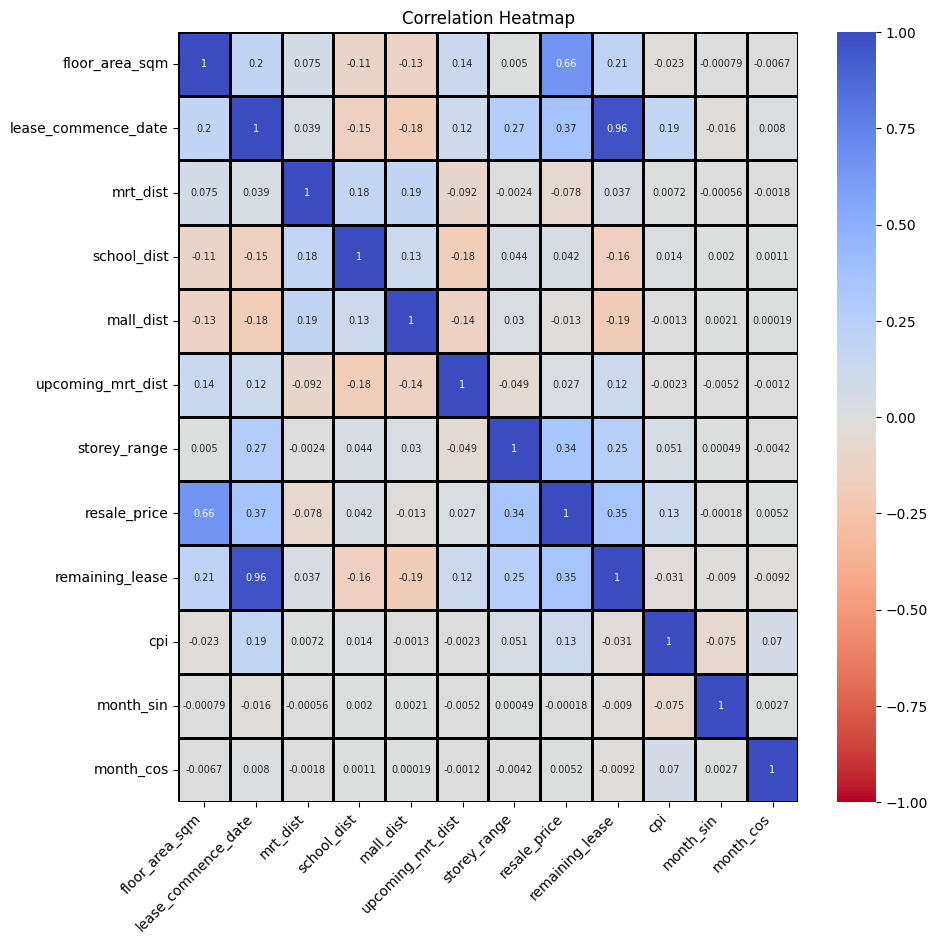

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(lr_df.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g',
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

In [35]:
import pandas as pd

# Correlation matrix
corr_matrix = lr_df.select_dtypes(include=['int64', 'float64']).corr()

corr_pairs = []

# Extract feature pairs and their correlation
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):  # j starts from i+1 to avoid duplicate pairs
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

corr_pairs_df = pd.DataFrame(corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
sorted_corr_pairs = corr_pairs_df.reindex(corr_pairs_df.Correlation.abs().sort_values(ascending=False).index)

# Filter out low correlations
threshold = 0.4
high_corr_pairs = sorted_corr_pairs[sorted_corr_pairs['Correlation'].abs() > threshold]

print(high_corr_pairs)

               Feature1         Feature2  Correlation
17  lease_commence_date  remaining_lease     0.962784
6        floor_area_sqm     resale_price     0.655672


#### 5.1.2.Linear Regression Analysis

In [36]:
lr_y = lr_df['resale_price']
lr_X = lr_df.drop(['resale_price', 'lease_commence_date', 'street_name', 'block', 'year'], axis=1)

In [37]:
from sklearn.linear_model import LinearRegression
import numpy as np

# sklearn method, which doesn't give much additional info

lin_reg = LinearRegression()
lin_reg.fit(lr_X, np.log(lr_y))

print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(lr_X, np.log(lr_y))}')

Coefficients: [ 0.17038981 -0.03380199  0.00323942 -0.0129409  -0.01848059  0.06799526
  0.00756525  0.00984146  0.00949003 -0.11095274 -0.0662514   0.24617736
 -0.04214685 -0.0579212   0.07668058 -0.02831196  0.02603357 -0.05185733
  0.09294138 -0.08439142  0.22686775  0.00904042 -0.13861348 -0.02030675
 -0.07698794  0.10401303  0.03674234  0.01522355 -0.02190048  0.04045572
 -0.09655126  0.14010644 -0.15117098  0.23307358 -0.11230115 -0.00439712
  0.04676367 -0.08720248 -0.05176835  0.2211876  -0.04609143 -0.1142902
  0.04208393 -0.07209726 -0.1302465   0.12461404  0.01838951 -0.06811999
 -0.08155748  0.01504127  0.00701737  0.00197504]
Intercept: 11.123501310409784
R^2 score: 0.8728779225597564


In [38]:
import statsmodels.api as sm
# alternate way using statistical formula, which does not require dummy coding manually
# https://stackoverflow.com/questions/50733014/linear-regression-with-dummy-categorical-variables
# https://stackoverflow.com/questions/34007308/linear-regression-analysis-with-string-categorical-features-variables

X_constant = sm.add_constant(lr_X)
lin_reg = sm.OLS(np.log(lr_y),X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 3.921e+04
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:07:49   Log-Likelihood:             2.0790e+05
No. Observations:              257030   AIC:                        -4.157e+05
Df Residuals:                  256984   BIC:                        -4.152e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.3257      0.005   1750.257      0.000       8.316       8.335
floor_area_sqm                   0.1704      0.001    210.581      0.000       0.169       0.172
mrt_dist                        -0.0338      0.000   -131.076      0.000      -0.034      -0.033
school_dist                      0.0032      0.000     12.764      0.000       0.003       0.004
mall_dist                       -0.0129      0.000    -47.923      0.000      -0.013      -0.012
upcoming_mrt_dist               -0.0185      0.001    -27.233      0.000      -0.020      -0.017
flat_type                        0.0680      0.001     73.848      0.000       0.066       0.070
storey_range                     0.0076   4.18e-05    181.032      0.000       0.007       0.008
remaining_lease                  0.0098   2.49e-05    395.141      0.000       0.010       0.010
cpi                              0.0095   4.09e-05    231.936      0.000       0.009       0.010
model_3Gen                       0.6459      0.020     32.981      0.000       0.608       0.684
model_Apartment                  0.6906      0.003    199.113      0.000       0.684       0.697
model_Improved-Maisonette        1.0031      0.019     52.168      0.000       0.965       1.041
model_Maisonette                 0.7147      0.004    196.938      0.000       0.708       0.722
model_Model A                    0.6990      0.003    203.479      0.000       0.692       0.706
model_Model A-Maisonette         0.8336      0.006    145.556      0.000       0.822       0.845
model_New Generation             0.7286      0.003    208.786      0.000       0.722       0.735
model_Premium Apartment Loft     0.7829      0.010     77.008      0.000       0.763       0.803
model_Premium Maisonette         0.7050      0.022     31.698      0.000       0.661       0.749
model_Special                    0.8498      0.004    222.172      0.000       0.842       0.857
model_Standard                   0.6725      0.003    195.244      0.000       0.666       0.679
region_Central                   2.0410      0.001   1724.983      0.000       2.039       2.043
region_East                      1.5397      0.001   1579.506      0.000       1.538       1.542
region_North                     1.3921      0.001   1221.043      0.000       1.390       1.394
region_North East                1.6805      0.001   1512.421      0.000       1.678       1.683
region_West                      1.6724      0.001   1337.744      0.000       1.670       1.675
town_ANG MO KIO                  0.4442      0.001    432.085      0.000       0.442       0.446
town_BEDOK                       0.5470      0.001    405.895      0.000       0.544       0.550
town_BISHAN                      0.2420      0.002    152.638      0.000    

#### 5.1.3.Training-Testing Data Split

In [39]:
resale_df_with_coord

,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,resale_price,year,remaining_lease,mrt_dist,...,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,month_sin,month_cos
0,1,406,ANG MO KIO AVE 10,2,44.0,1979,272090.176046,2012,66,0.004521,...,0,0,0,0,0,0,0,0,0.0,1.000000
1,1,314,ANG MO KIO AVE 3,8,44.0,1978,277578.418542,2012,65,0.003707,...,0,0,0,0,0,0,0,0,0.0,1.000000
2,1,314,ANG MO KIO AVE 3,11,44.0,1978,290243.593532,2012,65,0.003707,...,0,0,0,0,0,0,0,0,0.0,1.000000
3,1,170,ANG MO KIO AVE 4,2,45.0,1986,274412.124794,2012,73,0.002538,...,0,0,0,0,0,0,0,0,0.0,1.000000
4,1,174,ANG MO KIO AVE 4,8,45.0,1986,238527.462321,2012,73,0.003640,...,0,0,0,0,0,0,0,0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257126,5,325,YISHUN CTRL,5,146.0,1988,742839.373942,2024,63,0.001059,...,0,0,0,0,0,0,0,1,0.5,0.866025
257127,5,387,YISHUN RING RD,5,142.0,1988,708288.705386,2024,63,0.001722,...,0,0,0,0,0,0,0,1,0.5,0.866025
257128,5,355,YISHUN RING RD,2,154.0,1988,734201.706803,2024,63,0.004412,...,0,0,0,0,0,0,0,1,0.5,0.866025
257129,5,606,YISHUN ST 61,11,142.0,1987,686694.537539,2024,62,0.003777,...,0,0,0,0,0,0,0,1,0.5,0.866025


In [40]:
from sklearn.model_selection import train_test_split

# Train Test Split
y = resale_df_with_coord['resale_price']
X = resale_df_with_coord.drop(['resale_price', 'street_name', 'block', 'year'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, shuffle=True, random_state=0)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (231327, 53)
Shape of X_test: (25703, 53)
Shape of y_train: (231327,)
Shape of y_test: (25703,)


**`r2`**

In [41]:
cross_val_score(LinearRegression(),
                X_train, np.log(y_train),
                cv=3,
                scoring='r2').mean()

0.8786159709498538

**`rmse`**

In [42]:
cross_val_score(LinearRegression(),
                X_train, np.log(y_train),
                cv=3,
                scoring=rmse).mean()

0.10536486683918506

#### 5.1.4.Initial Random Forest Model

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr, pearsonr

# Validation using out-of-bag method
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=0)
rf.fit(X_train, y_train)
predicted_train = rf.predict(X_train)

print(f'Out-of-bag R\u00b2 score estimate: {rf.oob_score_:>5.3}')

Out-of-bag R² score estimate:  0.97


In [44]:
predicted_test = rf.predict(X_test)
oob_test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
oob_mae = mean_absolute_error(y_test, predicted_test)

print(f'Test data R\u00b2 score: {oob_test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')
print(f'Test data Mean Absolute Error: {round(oob_mae)}')

Test data R² score:  0.97
Test data Spearman correlation: 0.984
Test data Pearson correlation: 0.985
Test data Mean Absolute Error: 18270


**`rmse`**

In [45]:
print(f'Test data Root Mean Absolute Error: {np.sqrt(oob_mae)}')

Test data Root Mean Absolute Error: 135.16604118027038


In [46]:
y_test.values

array([346294.64727417, 237588.47695887, 371347.50360894, ...,
       579286.0149532 , 385750.17984299, 253809.63282206])

In [47]:
predicted_test

array([351146.21505911, 241882.49364109, 388005.77314305, ...,
       578964.40307027, 404001.91805929, 246391.51079316])

In [48]:
result1 = np.concatenate(([y_test.values], [predicted_test],[y_test.values - predicted_test])).T
result1_df = pd.DataFrame(result1, columns=['actual','predict','difference'])

In [49]:
result1_df

,actual,predict,difference
0,346294.647274,351146.215059,-4851.567785
1,237588.476959,241882.493641,-4294.016682
2,371347.503609,388005.773143,-16658.269534
3,482181.567698,457750.199889,24431.367808
4,235581.887262,255662.990332,-20081.103070
...,...,...,...
25698,542135.387887,546565.067596,-4429.679708
25699,393421.984420,407076.067666,-13654.083245
25700,579286.014953,578964.403070,321.611883
25701,385750.179843,404001.918059,-18251.738216


In [50]:
mrt_locations

,code,name,lat,lng,year,month
0,NS1,JURONG EAST,1.333295,103.742154,1990,3
1,NS2,BUKIT BATOK,1.349035,103.749526,1990,3
2,NS3,BUKIT GOMBAK,1.358663,103.751913,1990,3
3,NS4,CHOA CHU KANG,1.385363,103.744371,1990,3
4,NS5,YEW TEE,1.397476,103.747418,1996,2
...,...,...,...,...,...,...
157,TE17,OUTRAM PARK,1.280242,103.840052,2022,11
158,TE18,MAXWELL,1.280533,103.843884,2022,11
159,TE19,SHENTON WAY,1.277717,103.850368,2022,11
160,TE20,MARINA BAY,1.276311,103.854605,2022,11


### 5.2.Enhanced Model Exploration and Evaluation

In [51]:
from sklearn.model_selection import train_test_split

# Train Test Split
y = resale_df_with_coord['resale_price']
X = resale_df_with_coord.drop(['resale_price', 'lease_commence_date', 'street_name', 'block', 'year'], axis=1)

#### 5.2.1.Data Split for Linear and Advanced Models

In [52]:
y_log = np.log(y)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit to continuous columns and transform
scaled_columns = ['floor_area_sqm','mrt_dist','school_dist','mall_dist','upcoming_mrt_dist']
scaler.fit(X[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(X[scaled_columns]), index=X.index, columns=scaled_columns)

# separate unscaled features
unscaled_columns = X.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
X_scaled = pd.concat([scaled_columns,unscaled_columns], axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, shuffle=True, random_state=0)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (231327, 52)
Shape of X_test: (25703, 52)
Shape of y_train: (231327,)
Shape of y_test: (25703,)


In [55]:
X_scaled_train, X_scaled_test, y_log_train, y_log_test = train_test_split(X_scaled, y_log, test_size = 0.1, shuffle=True, random_state=0)
print('Shape of X_scaled_train:', X_scaled_train.shape)
print('Shape of X_scaled_test:', X_scaled_test.shape)
print('Shape of y_log_train:', y_log_train.shape)
print('Shape of y_log_test:', y_log_test.shape)

Shape of X_scaled_train: (231327, 52)
Shape of X_scaled_test: (25703, 52)
Shape of y_log_train: (231327,)
Shape of y_log_test: (25703,)


#### 5.2.2.Linear Model Variants (Linear Regression, Ridge Regression)

**`r2`**

In [56]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

cross_val_score(LinearRegression(), X_scaled_train, y_log_train, cv=3, scoring='r2').mean()

0.8729131925758707

**`rmse`**

In [57]:
cross_val_score(LinearRegression(), X_scaled_train, y_log_train, cv=3, scoring=rmse).mean()

0.10781146590687386

**`r2`**

In [58]:
cross_val_score(Ridge(), X_scaled_train, y_log_train, cv=5, scoring='r2').mean()

0.8729179752033465

**`rmse`**

In [59]:
cross_val_score(Ridge(), X_scaled_train, y_log_train, cv=5, scoring=rmse).mean()

0.1078086036013445

In [60]:
# GridSearch the Ridge regularization
param_grid =  {'alpha': np.linspace(0.5,2,num=20)}
search_ridge = GridSearchCV(estimator=Ridge(), param_grid=param_grid,
                            cv=5, n_jobs=-1, scoring=rmse_neg)

search_ridge.fit(X_scaled, y_log);

# print('Best estimator: ', search_ridge.best_estimator_)
print('Best params: ', search_ridge.best_params_)
print('Best RMSE (of log): ', -search_ridge.best_score_) # Inverse to turn into positive

Best params:  {'alpha': 0.5}
Best RMSE (of log):  0.12446374249276082


**`r2`**

In [61]:
cross_val_score(Ridge(alpha=0.5), X_scaled, y_log, cv=5, scoring='r2').mean()

0.8110654838227672

**`rmse`**

In [62]:
cross_val_score(Ridge(alpha=0.5), X_scaled, y_log, cv=5, scoring=rmse).mean()

0.12446374249276078

#### 5.2.3.K-Nearest Neighbors (KNN)

In [63]:
# GridSearch the KNN
from sklearn.neighbors import KNeighborsRegressor
param_grid =  {'n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
search_knn = GridSearchCV(KNeighborsRegressor(),
                          param_grid=param_grid,
                          cv=3, n_jobs=-1,
                          verbose=2, scoring=rmse_neg)

search_knn.fit(X_scaled, y_log);
print('Best params: ', search_knn.best_params_)
print('Best RMSE (of log): ', -search_knn.best_score_) # Inverse to turn into positive

Fitting 3 folds for each of 11 candidates, totalling 33 fits
Best params:  {'n_neighbors': 8}
Best RMSE (of log):  0.17433580543743532


In [64]:

scores = cross_val_score(KNeighborsRegressor(n_neighbors=8),
                         X_scaled, y_log,
                         cv=5,
                         scoring='r2',
                         verbose=False)

print('R2: ', scores.mean())

R2:  0.7469951600054523


#### 5.2.4.Decision Trees

In [65]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 score: ", r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # Set squared=False to get the square root directly
print("RMSE score: ", rmse)

R2 score:  0.9452970414192966
RMSE score:  34330.28649539501


#### 5.2.5.Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # Set squared=False to get the square root directly
print("RMSE score: ", rmse)

R2 score: 0.9556363257705125
RMSE score:  30916.17619506756


#### 5.2.6.Boosted Trees

In [67]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # Set squared=False to get the square root directly
print("RMSE score: ", rmse)

R2 score: 0.9676302060050626
RMSE score:  26408.39381119052


In [68]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, verbose=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # Set squared=False to get the square root directly
print("RMSE score: ", rmse)

R2 score: 0.8921559165589478
RMSE score:  48202.56865244318


#### 5.2.7.Model Stacking

In [69]:
from sklearn.ensemble import VotingRegressor, AdaBoostRegressor

rf = RandomForestRegressor()
ridge = Ridge()
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))

model = VotingRegressor(
    estimators = [("rf", rf),("adaboost", adaboost)],
    weights = [1,1],
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # Set squared=False to get the square root directly
print("RMSE score: ", rmse)

R2 score: 0.9697501259941029
RMSE score:  25529.000099415458


In [70]:
from sklearn.ensemble import StackingRegressor

rf = RandomForestRegressor()
ridge = Ridge()
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("adaboost", adaboost),
                ("ridge", ridge)],
    final_estimator=RandomForestRegressor(),
    cv=5,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # Set squared=False to get the square root directly
print("RMSE score: ", rmse)

R2 score: 0.9623176578444554
RMSE score:  28493.18279641881


### 5.3.Score Summary

| Model | R2 Score | RMSE |
|-|-|-|
| `LinearRegression` | 0.873 |  0.108 |
| `Ridge` | 0.873 | 0.108 |
| `KNeighborsRegressor` | 0.747 | 0.174 |
| `RandomForestRegressor` | 0.956 | 30916.17 |
| `DecisionTreeRegressor` | 0.945 | 34330.28 |
| `AdaBoostRegressor` | 0.968 | 26408.929 |
| `GradientBoostingRegressor` | 0.892 | 48202.569 |
| `VotingRegressor` with RandomForestRegressor and AdaBoostRegressor | 0.969 | 25529 | 
| `StackingRegressor` with AdaBoostRegressor, Ridge and RandomForestRegressor | 0.962 | 28493.182 |
